In [2]:
#!pip3 install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import minimize
import statsmodels.api as sm
import warnings

In [3]:
file_paths = [
    './Data/BIIB.OQ.csv',
    './Data/BIO.N.csv',
    './Data/LKQ.OQ.csv',
    './Data/TXT.N.csv',
    './Data/VRSK.OQ.csv',
    './Data/MKTX.OQ.csv'
]

# Si caricano i file
dataframes = [pd.read_csv(file) for file in file_paths]

In [4]:
# Vengono contati i valori NaN per ogni dataframe
nan_counts = [df.isna().sum().max() for df in dataframes]

# Viene trovato il dataframe con il numero più alto di NaN
max_nan_count = max(nan_counts)

In [5]:
processed_dfs = []
for df in dataframes:
    # Le prime righe vengono rimosse in base al conteggio massimo di Nan
    df = df.iloc[max_nan_count:].copy()

    # Conversione della colonna 'Date' in tipo di dato datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df['1 Month Total Return'] = df['1 Month Total Return']/100

    # Impostazione della data e ticker symbol come un indice multiplo
    df.set_index(['Date', 'Instrument'], inplace=True)

    # Si conserva solo la colonna '1 Month Total Return'
    df = df[['1 Month Total Return']]

    processed_dfs.append(df)

In [6]:
# Si uniscono tutti i dataframe
merged_data = pd.concat(processed_dfs, axis=0)

In [7]:
# 'Date' e 'Instrument' diventano colonne normali senza index
merged_data_reset = merged_data.reset_index()

returns = merged_data_reset.pivot(index='Date', columns='Instrument', values='1 Month Total Return')
returns

Instrument,BIIB.OQ,BIO.N,LKQ.OQ,MKTX.OQ,TXT.N,VRSK.OQ
Date,,,,,,
2009-10-30 00:00:00+00:00,-0.166073,-0.027101,-0.068501,-0.014108,-0.063224,0.007715
2009-11-30 00:00:00+00:00,0.114170,0.081665,0.009265,0.053882,0.127672,-0.018957
2009-12-31 00:00:00+00:00,0.139753,-0.002379,0.123924,0.116466,-0.060889,0.125232
2010-01-29 00:00:00+00:00,0.004486,-0.034004,-0.042879,-0.019424,0.038278,-0.071334
2010-02-26 00:00:00+00:00,0.032664,-0.011223,0.010554,0.102802,0.017365,-0.016336
...,...,...,...,...,...,...
2023-08-31 00:00:00+00:00,-0.010474,-0.012729,-0.036234,-0.102628,-0.000772,0.058006
2023-09-29 00:00:00+00:00,-0.038064,-0.096762,-0.074060,-0.121799,0.007613,-0.021131
2023-10-31 00:00:00+00:00,-0.075756,-0.232027,-0.112906,0.000515,-0.027387,-0.037589


In [8]:
df_without_header = returns.reset_index(drop=True) # Si rimuovono l'indice basato sulle date
df_without_header.columns.name = None # Si rimuovono i nomi delle colonne

ret = df_without_header.to_numpy()
ret

array([[-0.16607284, -0.02710057, -0.06850054, -0.01410788, -0.06322445,
         0.00771492],
       [ 0.11417042,  0.08166462,  0.00926462,  0.05388153,  0.12767154,
        -0.01895735],
       [ 0.13975288, -0.00237874,  0.12392427,  0.11646586, -0.06088906,
         0.12523226],
       ...,
       [-0.07575581, -0.23202678, -0.11290648,  0.00051488, -0.02738674,
        -0.03758889],
       [-0.01319506,  0.13197461,  0.03301478,  0.12499856,  0.01134565,
         0.07545993],
       [ 0.1055    ,  0.0589335 ,  0.0732    ,  0.2195    ,  0.04904   ,
        -0.01064   ]])

### 2. Estimate historical mean and variance covariance matrix of the stocks in your dataset with the methods described below. Estimate the variance covariance matrix with a Shrinkage toward Constant Correlation Approach (consider k=0.3). Estimate the vector of averages with an exponential average (lambda=0.01). Comment on the correlations among the stocks observed in your dataset.

#### 2.1

In [9]:
# Historical mean
er = merged_data.groupby(level='Instrument').mean()
er

,1 Month Total Return
Instrument,
BIIB.OQ,0.015302
BIO.N,0.010138
LKQ.OQ,0.014185
MKTX.OQ,0.024412
TXT.N,0.011330
VRSK.OQ,0.015259


#### Variance-covariance matrix

In [10]:
# Si raggruppano i dati seconodo 'Date' e 'Instrument'
aggregated_data = merged_data.groupby(level=['Date', 'Instrument']).mean()

# Si separa la colonna 'Instrument'
unstacked_data = aggregated_data.unstack(level='Instrument')

# Si calcola la matrice varianza-covarianza
V = unstacked_data.cov()
V

1 Month Total Return                      \
Instrument                                   BIIB.OQ     BIO.N    LKQ.OQ   
                     Instrument                                            
1 Month Total Return BIIB.OQ                0.009282  0.001361  0.001265   
                     BIO.N                  0.001361  0.006135  0.002281   
                     LKQ.OQ                 0.001265  0.002281  0.006246   
                     MKTX.OQ                0.001054  0.003260  0.001847   
                     TXT.N                  0.001875  0.002675  0.003050   
                     VRSK.OQ               -0.000100  0.001274  0.001216   

                                                               
Instrument                        MKTX.OQ     TXT.N   VRSK.OQ  
                     Instrument                                
1 Month Total Return BIIB.OQ     0.001054  0.001875 -0.000100  
                     BIO.N       0.003260  0.002675  0.001274  
                     LKQ.OQ      0.001847  0.003050  0.001216  
                     MKTX.OQ     0.008338  0.000752  0.000880  
                     TXT.N       0.000752  0.008406  0.001375  
                     VRSK.OQ     0.000880  0.001375  0.003266

#### 2.2

<b>Variance-Covariance matrix with a Shrinkage toward Constant Correlation Approach</b><br>

In [11]:
# Si calcola la matrice di correlazione
corr_matrix = unstacked_data.corr()
corr_matrix

1 Month Total Return                      \
Instrument                                   BIIB.OQ     BIO.N    LKQ.OQ   
                     Instrument                                            
1 Month Total Return BIIB.OQ                1.000000  0.180396  0.166144   
                     BIO.N                  0.180396  1.000000  0.368448   
                     LKQ.OQ                 0.166144  0.368448  1.000000   
                     MKTX.OQ                0.119771  0.455833  0.255986   
                     TXT.N                  0.212263  0.372479  0.420941   
                     VRSK.OQ               -0.018239  0.284605  0.269213   

                                                               
Instrument                        MKTX.OQ     TXT.N   VRSK.OQ  
                     Instrument                                
1 Month Total Return BIIB.OQ     0.119771  0.212263 -0.018239  
                     BIO.N       0.455833  0.372479  0.284605  
                     LKQ.OQ      0.255986  0.420941  0.269213  
                     MKTX.OQ     1.000000  0.089876  0.168684  
                     TXT.N       0.089876  1.000000  0.262360  
                     VRSK.OQ     0.168684  0.262360  1.000000

In [12]:
# Media delle correlazioni off-diagonal nella matrice di correlazione
rho = (corr_matrix.values.sum()-V.shape[0])/(V.shape[0]*(V.shape[0]-1)) # correlazione media tra gli strumenti 
rho

0.24058389134021438

In [13]:
diag_v = np.sqrt(np.diag(V)) # Calcolo deviazione standard

inv_D = np.zeros((len(diag_v), len(diag_v))) # Crea una matrice di zeri con la stessa dimensione della diagonale di V
np.fill_diagonal(inv_D, diag_v) # Si riempie la diagonale della matrice con i valori delle deviazioni standard 

print(inv_D)

[[0.09634193 0.         0.         0.         0.         0.        ]
 [0.         0.07832349 0.         0.         0.         0.        ]
 [0.         0.         0.0790329  0.         0.         0.        ]
 [0.         0.         0.         0.09131011 0.         0.        ]
 [0.         0.         0.         0.         0.09168499 0.        ]
 [0.         0.         0.         0.         0.         0.0571517 ]]


In [14]:
ones = [1,1,1,1,1,1] # Vettore di uni
theta_cc = np.full((6,6), rho) # Si crea una matrice 6x6 in cui ogni elemento è impostato al valore di rho
np.fill_diagonal(theta_cc, ones) # Si impostano gli elementi sulla diagonale con uni
print(theta_cc)

[[1.         0.24058389 0.24058389 0.24058389 0.24058389 0.24058389]
 [0.24058389 1.         0.24058389 0.24058389 0.24058389 0.24058389]
 [0.24058389 0.24058389 1.         0.24058389 0.24058389 0.24058389]
 [0.24058389 0.24058389 0.24058389 1.         0.24058389 0.24058389]
 [0.24058389 0.24058389 0.24058389 0.24058389 1.         0.24058389]
 [0.24058389 0.24058389 0.24058389 0.24058389 0.24058389 1.        ]]


In [15]:
V_cc = inv_D @ theta_cc @ inv_D # Matrice di covarianza calcolata moltiplicando la matrice di correlazione per le deviazioni standard degli strumenti due volte

In [16]:
k = 0.3
V_scc = k * V_cc + (1 - k) * V #  Matrice di covarianza combinata
V_scc

1 Month Total Return                      \
Instrument                                   BIIB.OQ     BIO.N    LKQ.OQ   
                     Instrument                                            
1 Month Total Return BIIB.OQ                0.009282  0.001497  0.001435   
                     BIO.N                  0.001497  0.006135  0.002043   
                     LKQ.OQ                 0.001435  0.002043  0.006246   
                     MKTX.OQ                0.001372  0.002798  0.001814   
                     TXT.N                  0.001950  0.002391  0.002658   
                     VRSK.OQ                0.000327  0.001215  0.001177   

                                                               
Instrument                        MKTX.OQ     TXT.N   VRSK.OQ  
                     Instrument                                
1 Month Total Return BIIB.OQ     0.001372  0.001950  0.000327  
                     BIO.N       0.002798  0.002391  0.001215  
                     LKQ.OQ      0.001814  0.002658  0.001177  
                     MKTX.OQ     0.008338  0.001131  0.000993  
                     TXT.N       0.001131  0.008406  0.001341  
                     VRSK.OQ     0.000993  0.001341  0.003266

#### 2.3

In [17]:
λ = 0.01
N = returns.shape[0]
t = np.arange(1, N + 1)

weights = np.exp(-λ * (N - t)) # Calcolo deii pesi esponenziali per ciascuna osservazione

weighted_returns_sum = (returns * weights[:, None]).sum() # Somma ponderata dei rendimenti
weights_sum = weights.sum() #  Somma totale dei pesi esponenziali

er_exp = weighted_returns_sum / weights_sum # Rendimenti attesi esponenzialmente ponderati
er_exp

Instrument
BIIB.OQ    0.009515
BIO.N      0.007945
LKQ.OQ     0.012005
MKTX.OQ    0.017870
TXT.N      0.011000
VRSK.OQ    0.014656
dtype: float64

-----

### 3. Plot the efficient portfolio frontier (in the standard deviation-mean space) with a risk-free asset (with annual return Rf=0.02). Comment on the obtained tangent portfolio (or risky asset portfolio).

In [18]:
rf_mensile = 0.02/12

In [19]:
# Markovitz
number_stocks = 6
Uno = pd.DataFrame({'A': np.ones(number_stocks)}) #DataFrame che contiene una sola colonna di uni, vettore di uni

# Calcolo dei diversi parametri chiave (A, B, C, D, g, h) usati nella formulazione di Markowitz
er_np = er.to_numpy()
A = Uno.T.to_numpy().dot(np.linalg.inv(V)).dot(er_np)
B = er.T.to_numpy().dot(np.linalg.inv(V)).dot(er_np)
C = Uno.T.to_numpy().dot(np.linalg.inv(V)).dot(Uno.to_numpy())
D = B*C-A**2
IV1 = np.linalg.inv(V).dot(Uno.to_numpy()) # Prodotto della matrice di covarianza inversa e il vettore di uno
IVE = np.linalg.inv(V).dot(er_np) # Prodotto della matrice di covarianza inversa e il vettore dei rendimenti attes
g = (B*IV1-A*IVE)/D
h = (C*IVE-A*IV1)/D


#### FP: N Risky Asset

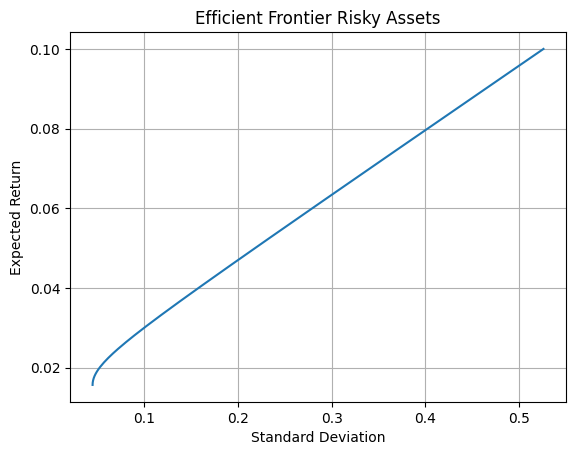

In [20]:
w_MVP = IV1/C # Calcolo dei pesi del portafoglio
er_min = A/C # Rendimento atteso del Minimum Variance Portfolio


m = np.linspace(A/C, 0.1, 150) # Vettore di 50 punti equidistanti che vanno dal rendimento atteso del MVP (A/C) a 0.1
Var_w = (C / D) * ((m - A/C)) ** 2 + 1/C # Calcolo della varianza del portafoglio per ogni valore di rendimento atteso
Var_w = Var_w.flatten()
m = m.flatten()

# Rappresentazione grafica della parte efficiente della frontiera del portafoglio
plt.figure()
plt.plot(np.sqrt(Var_w), m)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier Risky Assets')
plt.grid(True)
plt.show()


#### FP*: N Risky Asset + RF

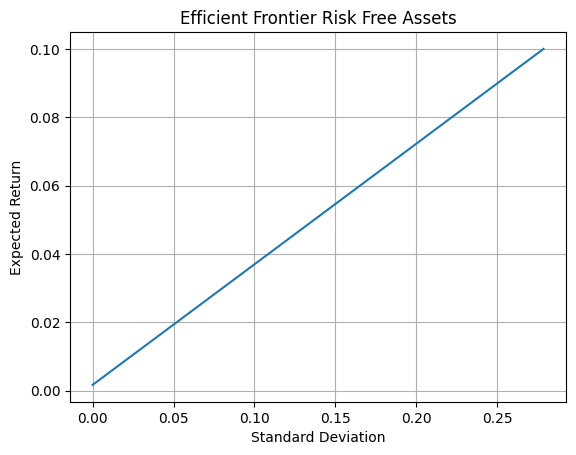

In [21]:
H = B-2 * A * rf_mensile + C * (rf_mensile)**2 # Calcolo di H che descrive la relazione tra il rendimento atteso e la varianza di un portafoglio che include un asset senza rischio

mr = np.linspace(rf_mensile, 0.1, 150) # Vettore di 50 punti equidistanti che vanno dal rendimento atteso del MVP (A/C) a 0.1
var_rf = ((mr-rf_mensile)**2)/H # Calcolo della varianza del portafoglio per ogni valore di rendimento atteso in mr quando è incluso un asset senza rischio

var_rf = var_rf.flatten()
mr = mr.flatten()

# Grafico della frontiera efficiente che include l'asset senza rischio
plt.figure()
plt.plot(np.sqrt(var_rf), mr)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier Risk Free Assets')
plt.grid(True)
plt.show()

In [22]:
# Calcolo dei pesi del portafoglio tangenziale
step1 = er_np-rf_mensile * Uno # Calcolo del rendimento in eccesso per ogni azione
step2 = Uno.T.to_numpy().dot(np.linalg.inv(V)) # Calcolo del prodotto del vettore di uni trasposto e la matrice di covarianza inversa
step3 = step2.dot(step1) # Normalizzazione dei pesi del portafoglio tangenziale
step4 = step1/step3 # Normalizzazione del vettore di rendimenti in eccesso in modo che la loro somma ponderata sia uguale a 1

In [23]:
w_tan = np.linalg.inv(V).dot(step4) # Calcolo dei pesi del portafoglio tangenziale moltiplicando la matrice di covarianza inversa per il vettore normalizzato di rendimenti in eccesso
w_tan

array([[ 0.18232841],
       [-0.19415011],
       [ 0.09353203],
       [ 0.36051183],
       [ 0.03187048],
       [ 0.52590736]])

In [24]:
std_w_tan = np.sqrt(w_tan.T.dot(V).dot(w_tan)) # Calcolo della deviazione standard, volatilità, del portafoglio tangenziale
er_w_tan = w_tan.T.dot(er_np) # Calcolo del rendimento atteso del portafoglio tangenziale

In [25]:
std_w_tan

array([[0.0500492]])

In [26]:
er_w_tan

array([[0.019335]])

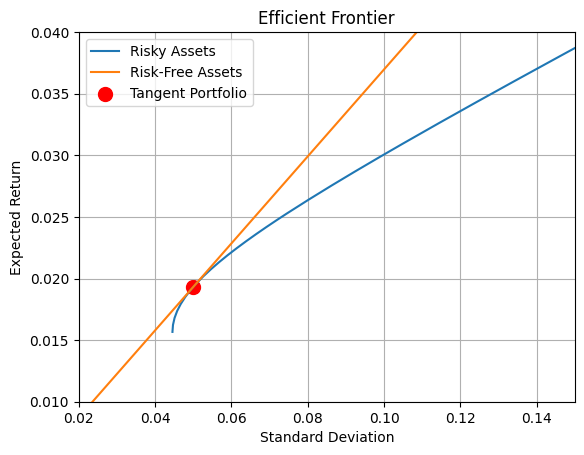

In [27]:
# Rappresentazione grafica dell'intera frontiera efficiente 
plt.figure()

plt.plot(np.sqrt(Var_w), m, label='Risky Assets') # Frontiera efficiente per gli asset rischiosi
plt.plot(np.sqrt(var_rf), mr, label='Risk-Free Assets') # Frontiera efficiente per gli asset senza rischio
plt.scatter(std_w_tan, er_w_tan, color='red', label='Tangent Portfolio', s=100) # Punto che rappresenta il portafoglio tangenziale

plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')

plt.title('Efficient Frontier')
plt.legend()

plt.xlim(0.02, 0.15)
plt.ylim(0.01, 0.04)

plt.grid(True)
plt.show()


---

### 4. Compute and plot the efficient portfolio frontier with the same risk-free asset but imposing a no short-selling constraint. Comment on the differences on the portfolio with 0.5% monthly expected return with and without the short-selling constraint.

#### Linear Optimizer N risky assets

In [28]:
w_MVP = w_MVP.flatten().tolist()


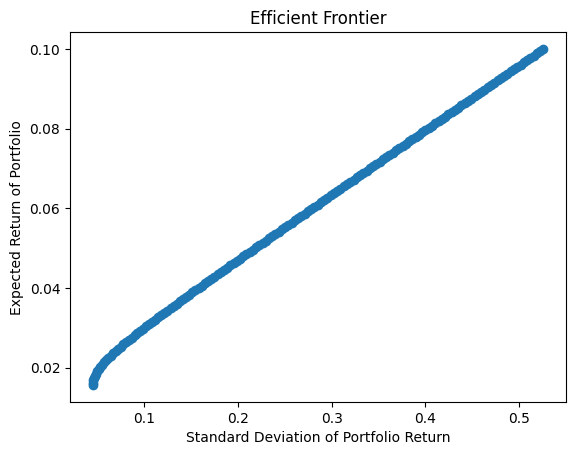

In [29]:
ones_row = np.ones((1, er.values.shape[0])) # Vettore di uni con la stessa lunghezza del numero di asset nel portafoglio
Aeq = np.vstack((er.values.T, ones_row))

# Calcolo della varianza del portafoglio per un dato vettore di pesi w e una matrice di covarianza Sigma. 
# L'obiettivo è minimizzare questa varianza.
def objective(w, Sigma):
    return w @ Sigma @ w

var_w_num_list=[]


for target_return in m: # m contiene i diversi rendimenti attesi target per i quali si desidera ottimizzare i pesi del portafoglio
    beq = np.array([target_return]) # Definisce il rendimento atteso target per l'attuale iterazione del ciclo
    
    # Vincoli di uguaglianza
    constraints = [
        {'type': 'eq', 'fun': lambda w: w @ er - beq},  # Vincolo che assicura il rendimento atteso del portafoglio, calcolato come prodotto scalare dei pesi del portafoglio e il vettore dei rendimenti attesi, sia uguale al rendimento atteso target
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},   # Vincolo che garantisce che la somma dei pesi del portafoglio w sia uguale a 1
    ]
    
    # Impostazione dei pesi del MVP come il punto di partenza, guess iniziale, per l'ottimizzazione
    w0 = w_MVP
    
    # Ottimizzazione dei pesi del portafoglio utilizzando il metodo Sequential Least SQuares Programming (SLSQP)
    result = minimize(fun=objective, x0=w0, args=(V,), method='SLSQP', constraints=constraints)
    
    # Dopo aver eseguito l'ottimizzazione si controlla che sia stata completata con successo
    if not result.success:
        raise ValueError(result.message)
    
    ww = result.x # Estrarre i pesi ottimizzati del portafoglio dal risultato dell'ottimizzazione
    
    var_w_num = ww @ V @ ww # Calcolo della varianza del portafoglio utilizzando i pesi ottimizzati e la matrice di covarianza
    
    # print(f"Target return: {target_return}, Variance: {var_w_num}")
    var_w_num_list.append(var_w_num)


# Conversione dei risultati in array NumPy per la rappresentazione grafica
var_w_num_array = np.array(var_w_num_list)
m_array = np.array(m)

# Grafica
plt.plot(np.sqrt(var_w_num_array), m_array, 'o') # Calcolo della deviazione standard del portafoglio per ciascun rendimento target
plt.xlabel('Standard Deviation of Portfolio Return')
plt.ylabel('Expected Return of Portfolio')
plt.title('Efficient Frontier')
plt.show()


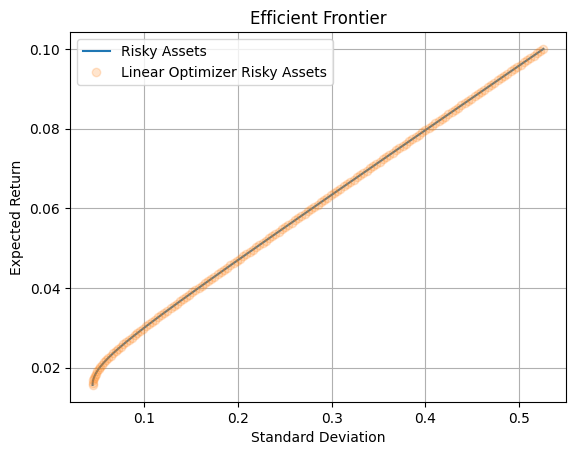

In [30]:
# Grafico della frontiera efficiente e l'ottinizzatore
plt.figure()

plt.plot(np.sqrt(Var_w), m, label='Risky Assets') # Frontiera efficiente per gli asset rischiosi
plt.plot(np.sqrt(var_w_num_array), m_array, 'o', alpha=0.2, label='Linear Optimizer Risky Assets') #Ffrontiera efficiente ottenuta tramite l'ottimizzazione lineare

plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

plt.legend()
plt.grid(True)
plt.show()


#### Linear Optimizer Risk Free

In [31]:
Aeq = np.vstack((er.values.T-rf_mensile)) # Calcolo del rendimento in eccesso sottraendo il tasso di rendimento senza rischio

# Calcolo della varianza del portafoglio per un dato vettore di pesi w e una matrice di covarianza Sigma. 
# L'obiettivo è minimizzare questa varianza.
def objective(w, Sigma):
    return w @ Sigma @ w

var_w_num_list=[]


for target_return in mr: # mr contiene i diversi rendimenti attesi target (dopo aver sottratto il rendimento senza rischio) per i quali si desidera ottimizzare i pesi del portafoglio
    beq = np.array([target_return-rf_mensile])  # Definisce il rendimento atteso target per l'attuale iterazione del ciclo
    
    constraints = [
        {'type': 'eq', 'fun': lambda w: w @ (er-rf_mensile) - beq},  # Calcola il rendimento atteso del portafoglio aggiustato per il rendimento senza rischio
    ]
    

    # Impostazione dei pesi del MVP come il punto di partenza, guess iniziale, per l'ottimizzazione
    w0 = w_MVP
    
    # Ottimizzazione dei pesi del portafoglio utilizzando il metodo Sequential Least SQuares Programming (SLSQP)
    result = minimize(fun=objective, x0=w0, args=(V,), method='SLSQP', constraints=constraints)
    
    # Dopo aver eseguito l'ottimizzazione si controlla che sia stata completata con successo
    if not result.success:
        raise ValueError(result.message)
    
    
    ww = result.x # Estrarre i pesi ottimizzati del portafoglio dal risultato dell'ottimizzazione
    
    
    var_w_num = ww @ V @ ww # Calcolo della varianza del portafoglio utilizzando i pesi ottimizzati e la matrice di covarianza
    
    # print(f"Target return: {target_return}, Variance: {var_w_num}")
    var_w_num_list.append(var_w_num)

# Conversione dei risultati in array NumPy per la rappresentazione grafica
var_w_num_array = np.array(var_w_num_list)
m_array = np.array(mr)

##### Linear optimizer risk free 1st Constraint

In [32]:
Aeq = np.vstack((er.values.T-rf_mensile)) # Calcolo del rendimento in eccesso sottraendo il tasso di rendimento senza rischio

# Calcolo della varianza del portafoglio per un dato vettore di pesi w e una matrice di covarianza Sigma. 
# L'obiettivo è minimizzare questa varianza.
def objective(w, Sigma):
    return w @ Sigma @ w

var_w_num_list=[]


for target_return in mr: # mr contiene i diversi rendimenti attesi target (dopo aver sottratto il rendimento senza rischio) per i quali si desidera ottimizzare i pesi del portafoglio
    beq = np.array([target_return-rf_mensile]) # Definisce il rendimento atteso target per l'attuale iterazione del ciclo
    
    
    constraints = [
        {'type': 'eq', 'fun': lambda w: w @ (er-rf_mensile) - beq},  # Expected return constraint
        {'type': 'eq', 'fun': lambda w: w[0] + w[1] - 0.5}  # First two weights sum to 50%
    ]
    
    # Impostazione dei pesi del MVP come il punto di partenza, guess iniziale, per l'ottimizzazione
    w0 = w_MVP
    
    # Ottimizzazione dei pesi del portafoglio utilizzando il metodo Sequential Least SQuares Programming (SLSQP)
    result = minimize(fun=objective, x0=w0, args=(V,), method='SLSQP', constraints=constraints)
    
    
    # Dopo aver eseguito l'ottimizzazione si controlla che sia stata completata con successo
    if not result.success:
        raise ValueError(result.message)
    
    
    ww = result.x # Estrarre i pesi ottimizzati del portafoglio dal risultato dell'ottimizzazione
    
    
    var_w_num = ww @ V @ ww # Calcolo della varianza del portafoglio utilizzando i pesi ottimizzati e la matrice di covarianza
    
    # print(f"Target return: {target_return}, Variance: {var_w_num}")
    var_w_num_list.append(var_w_num)

# Conversione dei risultati in array NumPy per la rappresentazione grafica
var_w_num_array = np.array(var_w_num_list)
m_array = np.array(mr)



##### Linear optimizer risk free 2nd Constraint

In [33]:
# Calcolo della varianza del portafoglio per un dato vettore di pesi w e una matrice di covarianza Sigma. 
# L'obiettivo è minimizzare questa varianza.
def objective(w, V):
    return w.T @ V @ w

warnings.filterwarnings('ignore')

var_w_num_list = []
# Array utilizzate per memorizzare i risultati delle ottimizzazioni riuscite
successful_m = [] 
successful_weights = []
# Array utilizzate per memorizzare i risultati delle ottimizzazioni falite
failed_m = []  
failed_details = [] 


lower_bound = 0.10 # Variabile utilizzata per stabilire un limite inferiore, del 10%, per il peso di ogni titolo nel portafoglio (ogni titolo può essere 10% o più)

bounds = [(lower_bound, None) for _ in range(number_stocks)] # Crea una lista di tuple che definiscono i limiti (inferiore e superiore) per i pesi di ciascun titolo

options = {'maxiter': 1000, 'disp': False}

for target_return in mr:
    
    constraints = [
        {'type': 'eq', 'fun': lambda w: w @ (er-rf_mensile) -  np.array([target_return-rf_mensile])}, # Assicura che il rendimento atteso del portafoglio, dopo aver sottratto il rendimento senza rischio, sia esattamente uguale al rendimento target desiderato
        # Questo vincolo è di tipo 'ineq', che sta per disuguaglianza (10% o più)
        {'type': 'ineq', 'fun': lambda w: w - lower_bound} #  Assicura che ciascun asset nel portafoglio deve avere un peso di almeno il 10%
    ]

    # Punto di partenza per l'ottimizzazione, basato sui pesi del portafoglio di minima varianza
    w0 = w_MVP

    # Ottimizzazione dei pesi del portafoglio utilizzando il metodo Sequential Least SQuares Programming (SLSQP)
    result = minimize(fun=objective, x0=w0, args=(V,), method='SLSQP', constraints=constraints, bounds=bounds, options=options)
    
    # Dopo aver eseguito l'ottimizzazione si controlla che sia stata completata con successo, o si vede se falisce
    if result.success:
        ww = result.x
        var_w_num = ww.T @ V @ ww
        var_w_num_list.append(var_w_num)
        successful_m.append(target_return)
        successful_weights.append(ww) 
    else:
        # print(f"Optimization failed for target return {target_return}: {result.message}")
        failed_m.append(target_return)
        failed_details.append((target_return, result.x, result.message)) 

# Conversione dei risultati in array NumPy per la rappresentazione grafica
var_w_num_array_2 = np.array(var_w_num_list)
successful_m_array_2 = np.array(successful_m)


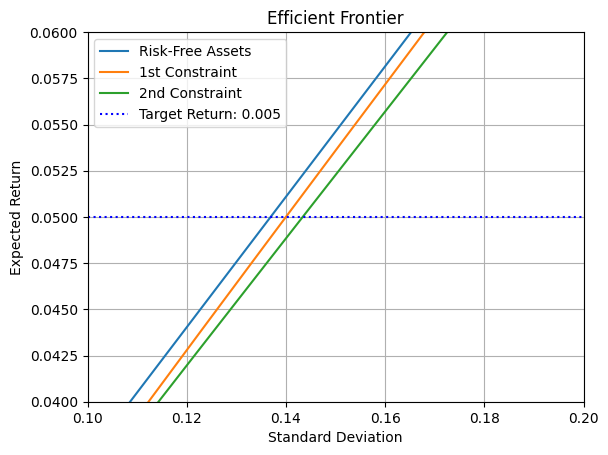

In [34]:
# Grafico della frontiera efficiente risk free assets e i 2 constraints
plt.figure()

plt.plot(np.sqrt(var_rf), mr, label='Risk-Free Assets')
plt.plot(np.sqrt(var_w_num_array), m_array,  label='1st Constraint')
plt.plot(np.sqrt(var_w_num_array_2), successful_m_array_2, label='2nd Constraint')
plt.axhline(y = 0.05, color = 'b', linestyle = ':', label='Target Return: 0.005') 

plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

plt.xlim(0.10, 0.20)
plt.ylim(0.04, 0.06)

plt.legend()
plt.grid(True)
plt.show()


In [35]:
def find_intersection(x_values, y_values, target_y):
    for i in range(len(y_values) - 1):
        if y_values[i] <= target_y <= y_values[i + 1] or y_values[i] >= target_y >= y_values[i + 1]:
            x1, x2 = x_values[i], x_values[i + 1]
            y1, y2 = y_values[i], y_values[i + 1]
            return x1 + (target_y - y1) * (x2 - x1) / (y2 - y1)
    return None

target_y = 0.05

# Trova i punti di intersezioni
σ_FPrf = find_intersection(np.sqrt(var_rf), mr, target_y) # Asset senza rischio
σ_1stC = find_intersection(np.sqrt(var_w_num_array), m_array, target_y) # Primo vincolo
σ_2ndC = find_intersection(np.sqrt(var_w_num_array_2), successful_m_array_2, target_y) # Secondo vincolo

print("Intersection with Risk-Free Assets:", σ_FPrf)
print("Intersection with 1st constraint:", σ_1stC)
print("Intersection with 2nd constraint:", σ_2ndC)


Intersection with Risk-Free Assets: 0.1369141123879904
Intersection with 1st constraint: 0.13999451158594073
Intersection with 2nd constraint: 0.14338789263976165


---

###  5. Estimate CAPM alpha and beta for your stocks, use the returns of the S&P 500 (you should obtain returns from S&P 500 prices) as proxy for the market returns. Comment on the results, which of the stocks has generated alpha in the previous years? Assume Rf=0.02.

In [36]:
# Si caricano i dati del S&P 500 
sp500_data_path = './Data/SPX.csv'
sp500_data = pd.read_csv(sp500_data_path)

# La colonna 'Date' viene convertita in un formato di data e ora
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

# Calcolo dei rendimenti percentuali del S&P 500
sp500_data['SPX_Returns'] = sp500_data['Price Close'].pct_change()

In [37]:
# Si allineano i due set di dati dove solo le date presenti in entrambi i set saranno mantenute
aligned_data = unstacked_data['1 Month Total Return'].align(sp500_data['SPX_Returns'], axis=0, join='inner')
stock_returns, market_returns = aligned_data[0], aligned_data[1]

In [38]:
rp_stock = stock_returns-rf_mensile # Calcolo del rendimento in eccesso delle azioni
rp_mkt = market_returns-rf_mensile # Calcolo del rendimento in eccesso del mercato

In [39]:

for stock in rp_stock.columns: # Itera attraverso ogni colonna (ogni stock) in rp_stock
    # Prepare data for regression
    X = sm.add_constant(rp_mkt)  # Aggiunge una colonna di costanti
    y = rp_stock[stock]  # Impostazione dei rendimenti in eccesso dell'azione corrente come variabile dipendente

    # Si utilizza il metodo dei minimi quadrati ordinari (OLS) per adattare un modello lineare
    model = sm.OLS(y, X, missing='drop').fit() 
    alpha, beta = model.params # Estrae i parametri della regressione dal modello

    print(f"Stock: {stock}")
    print(f"Alpha (α): {alpha}, Beta (β): {beta}\n")


Stock: BIIB.OQ
Alpha (α): 0.008673342952396254, Beta (β): 0.6134364039378843

Stock: BIO.N
Alpha (α): -0.00012271887266981452, Beta (β): 1.062425485988645

Stock: LKQ.OQ
Alpha (α): 0.003253389424089446, Beta (β): 1.1453687422679177

Stock: MKTX.OQ
Alpha (α): 0.016432727077954325, Beta (β): 0.7803618845544887

Stock: TXT.N
Alpha (α): -0.002360012697490936, Beta (β): 1.48637150454777

Stock: VRSK.OQ
Alpha (α): 0.008544731088086097, Beta (β): 0.6239931820251903



---

### 6. Compute market implicit returns Π in a Black Litterman framework. And compute the market portfolio.

In [40]:
# Si aggiunge la colonna di 'Company Market Cap'
dataframes_market_cap = [pd.read_csv(file, usecols=['Instrument', 'Date', 'Company Market Cap']) for file in file_paths]

processed_market_cap_dfs = []
for df in dataframes_market_cap:
    # Conversione della colonna 'Date' in tipo di dato datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Impostazione della data e instrument come un indice multiplo
    df.set_index(['Date', 'Instrument'], inplace=True)
    processed_market_cap_dfs.append(df)

# Unione di tutti i dataframe
merged_market_cap_data = pd.concat(processed_market_cap_dfs, axis=0)

In [41]:
# Calcolo dell'ultima capitalizzazione di mercato registrata per ciascuno strumento finanziario
market_caps = merged_market_cap_data.groupby(level='Instrument')['Company Market Cap'].last()

In [42]:
# Variabile che definisce il coefficiente di avversione al rischio
tau = 1

total_market_cap = market_caps.sum() # Calcolo della capitalizzazione di mercato totale sommando le capitalizzazioni di mercato di tutti gli strumenti
market_weights = market_caps / total_market_cap # Calcolao dei pesi di mercato per ciascun strumento 

#  Calcolo dei rendimenti impliciti del mercato
Pi = np.dot(tau * V, market_weights)

print("\nMarket Implicit Returns (Π):")
print(Pi)

print("\nMarket weights:")
print(market_weights)


Market Implicit Returns (Π):
[0.00342307 0.00214873 0.00214073 0.00188716 0.00266465 0.00138894]

Market weights:
Instrument
BIIB.OQ    0.309454
BIO.N      0.077661
LKQ.OQ     0.105462
MKTX.OQ    0.091599
TXT.N      0.130053
VRSK.OQ    0.285771
Name: Company Market Cap, dtype: float64


In [43]:
w_BL = np.linalg.inv(V)@Pi # Pesi ottimali del portafoglio secondo il modello Black-Litterman.
w_BL = w_BL.reshape(6,1) # Transformazione del vettore a 6x1
w_BL

array([[0.30945445],
       [0.07766069],
       [0.10546208],
       [0.09159852],
       [0.13005339],
       [0.28577087]])

----

### 7.	Formulate at least two Black Litterman views for the returns of the stocks in your portfolio for January 2024 (for formulating the views you can use historical averages, news and or public balance sheet data). Comment on the Black Litterman portfolio obtained when considering your views.

**BIIB.OQ (Biogen Inc.) - Views**

**View 1:**
- **Expected Return:** 7%
- **Confidence Level:** High (70%)
- **Rationale:** Strong results from new Alzheimer's drug trials.

**MKTX.OQ (MarketAxess) - Views**

**View 2:**
- **Expected Return:** 1%
- **Confidence Level:** Low (30%)
- **Rationale:** Regulatory changes potentially impacting operations.

In [44]:
k = 2 # Numero di viste, views
m = number_stocks
coef_1 = (1-0.07)/0.07
coef_2 = (1-0.03)/0.03

# Matrice che definisce le viste 
P = np.matrix([[1,0,0,0,0,0],
               [0,0,0,1,0,0]]) 
P1 = np.array(P[0])
P2 = np.array(P[1])

# Vettore che rappresenta i rendimenti attesi associati a ciascuna vista
Q = np.matrix([[0.07],
               [0.01]])


In [45]:
# Calcolo della varianza di ciascuna vista
Ω_11 = (P1@V).dot(P1.T)*coef_1
Ω_22 = (P2@V).dot(P2.T)*coef_2

# Calcolo della matrice di incertezza
Ω = np.matrix([[Ω_11.iloc[0, 0], 0],[0, Ω_22.iloc[0, 0]]])
Ω


matrix([[0.12331492, 0.        ],
        [0.        , 0.26958036]])

In [46]:
step1 = P.T.dot(np.linalg.inv(Ω)).dot(P)
step2 = np.array(P.T.dot(np.linalg.inv(Ω)).dot(Q))

Pi_new_1 = (np.linalg.inv(np.linalg.inv(V)+step1)) # Aggiustamento della matrice di covarianza originale, incorporando l'informazione delle viste e della loro incertezza
Pi_new_2 = (np.linalg.inv(V)@Pi+step2.flatten()) # Calcola un termine che aggiunge l'effetto delle viste agli originali rendimenti impliciti del mercato

Pi_new = np.array(Pi_new_1@Pi_new_2) # Nuovi rendimenti attesi 
Pi_new = Pi_new.reshape((6, 1)) # Vettore 6x1

V_new = Pi_new_1 # Impostazione della nuova matrice di covarianza
W_BL_new = np.linalg.inv(V_new)@Pi_new # Calcolo dei nuovi pesi del portafoglio



In [47]:
V_new

matrix([[ 8.62858940e-03,  1.25449253e-03,  1.17001659e-03,
          9.50503975e-04,  1.74109545e-03, -9.65039894e-05],
        [ 1.25449253e-03,  6.08260719e-03,  2.24627163e-03,
          3.15179664e-03,  2.64693397e-03,  1.26471352e-03],
        [ 1.17001659e-03,  2.24627163e-03,  6.22198399e-03,
          1.78220597e-03,  3.02743173e-03,  1.21113261e-03],
        [ 9.50503975e-04,  3.15179664e-03,  1.78220597e-03,
          8.07953310e-03,  7.15418769e-04,  8.54671279e-04],
        [ 1.74109545e-03,  2.64693397e-03,  3.02743173e-03,
          7.15418769e-04,  8.37766763e-03,  1.37383540e-03],
        [-9.65039894e-05,  1.26471352e-03,  1.21113261e-03,
          8.54671279e-04,  1.37383540e-03,  3.26344734e-03]])

In [48]:
W_BL_new, w_BL

(matrix([[0.87710678],
         [0.07766069],
         [0.10546208],
         [0.12869321],
         [0.13005339],
         [0.28577087]]),
 array([[0.30945445],
        [0.07766069],
        [0.10546208],
        [0.09159852],
        [0.13005339],
        [0.28577087]]))

In [49]:
std_W_BL_new = np.sqrt(W_BL_new.T.dot(V_new).dot(W_BL_new)) # Calcolo della deviazione standard, volatilità, del portafoglio W_BL_new
er_W_BL_new = W_BL_new.T.dot(er_np) # Calcolo del rendimento atteso del portafoglio W_BL_new
print(std_W_BL_new,er_W_BL_new)

[[0.09401893]] [[0.02468045]]
